In [ ]:
from google.colab import drive
import tarfile
import os
import shutil

# --- Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- Define Paths ---
# This path points to the file inside the folder you showed in the screenshot
drive_tar_path = '/content/drive/MyDrive/train-CNN+LSTM+BO/train_2D_keypoints.tar.gz'
extract_folder = 'full_train_keypoints'

# --- Extract ---
# Ensure the extraction folder is clean before starting
if os.path.exists(extract_folder):
    shutil.rmtree(extract_folder)
os.makedirs(extract_folder)

print(f"\nAttempting to extract {drive_tar_path}...")

# Check if the file exists at the specified path before trying to extract
if os.path.exists(drive_tar_path):
    try:
        with tarfile.open(drive_tar_path, 'r:gz') as tar:
            tar.extractall(path=extract_folder)
        print("Extraction complete.")

        # Verify by listing some of the extracted contents
        print(f"\nVerification: Here are some of the first items in '{extract_folder}':")
        extracted_contents = os.listdir(extract_folder)
        for item in extracted_contents[:5]:
            print(f"  - {item}")

    except Exception as e:
        print(f"An error occurred during extraction: {e}")
else:
    print(f"ERROR: File not found at '{drive_tar_path}'.")
    print("Please double-check the folder and file names in your Google Drive.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.

Attempting to extract /content/drive/MyDrive/train-CNN+LSTM+BO/train_2D_keypoints.tar.gz...
Extraction complete.

Verification: Here are some of the first items in 'full_train_keypoints':
  - openpose_output


In [ ]:
from google.colab import drive
import tarfile
import os
import shutil

# --- Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# --- Define Paths ---
drive_tar_path = '/content/drive/MyDrive/train-CNN+LSTM+BO/val_2D_keypoints.tar.gz'
# --- THIS IS THE FIX ---
extract_folder = 'full_validation_keypoints' # Corrected folder name

# --- Extract ---
if os.path.exists(extract_folder):
    shutil.rmtree(extract_folder)
os.makedirs(extract_folder)

print(f"\nAttempting to extract {drive_tar_path}...")

if os.path.exists(drive_tar_path):
    try:
        with tarfile.open(drive_tar_path, 'r:gz') as tar:
            tar.extractall(path=extract_folder)
        print("Extraction complete.")

        print(f"\nVerification: Here are some of the first items in '{extract_folder}':")
        extracted_contents = os.listdir(extract_folder)
        for item in extracted_contents[:5]:
            print(f"  - {item}")

    except Exception as e:
        print(f"An error occurred during extraction: {e}")
else:
    print(f"ERROR: File not found at '{drive_tar_path}'.")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.

Attempting to extract /content/drive/MyDrive/train-CNN+LSTM+BO/val_2D_keypoints.tar.gz...
Extraction complete.

Verification: Here are some of the first items in 'full_validation_keypoints':
  - openpose_output


In [ ]:
import json
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# --- Parameters & Setup ---
MAX_FRAMES = 30
TRAIN_DATA_FOLDER = 'full_train_keypoints/openpose_output/json'
VAL_DATA_FOLDER = 'full_validation_keypoints/openpose_output/json'
TRAIN_LABELS_CSV = 'how2sign_realigned_train.csv'
VAL_LABELS_CSV = 'how2sign_realigned_val.csv'

# --- Load the separate CSV files ---
try:
    train_labels_df = pd.read_csv(TRAIN_LABELS_CSV, sep='\t')
    val_labels_df = pd.read_csv(VAL_LABELS_CSV, sep='\t')

    # Create specific label maps for each dataset
    train_label_map = pd.Series(train_labels_df.SENTENCE.values, index=train_labels_df.SENTENCE_NAME).to_dict()
    val_label_map = pd.Series(val_labels_df.SENTENCE.values, index=val_labels_df.SENTENCE_NAME).to_dict()
except FileNotFoundError as e:
    print(f"ERROR: A label file was not found. Please check filenames. Details: {e}")
    exit()

# --- Reusable Data Processing Functions ---
def load_and_process_keypoints(sequence_path):
    json_files = sorted([os.path.join(sequence_path, f) for f in os.listdir(sequence_path) if f.endswith('.json')])
    sequence_data = []
    for file_path in json_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
        if not data['people']: continue
        person = data['people'][0]
        pose_kps = np.array(person['pose_keypoints_2d']).reshape(-1, 3)[:, :2].flatten()
        face_kps = np.array(person['face_keypoints_2d']).reshape(-1, 3)[:, :2].flatten()
        hand_left_kps = np.array(person['hand_left_keypoints_2d']).reshape(-1, 3)[:, :2].flatten()
        hand_right_kps = np.array(person['hand_right_keypoints_2d']).reshape(-1, 3)[:, :2].flatten()
        frame_features = np.concatenate([pose_kps, face_kps, hand_left_kps, hand_right_kps])
        sequence_data.append(frame_features)
    return np.array(sequence_data)

def create_dataset(data_folder, label_map, max_frames):
    X, y = [], []
    sequence_folders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]

    for seq_folder in sequence_folders:
        if seq_folder in label_map:
            keypoints = load_and_process_keypoints(os.path.join(data_folder, seq_folder))
            if keypoints.size == 0: continue

            if len(keypoints) > max_frames:
                keypoints = keypoints[:max_frames]
            elif len(keypoints) < max_frames:
                padding_needed = max_frames - len(keypoints)
                keypoints = np.pad(keypoints, ((0, padding_needed), (0, 0)), mode='constant')

            X.append(keypoints)
            y.append(label_map[seq_folder])

    return np.array(X, dtype='float32'), np.array(y)

# --- Process TRAIN and VALIDATION data using their respective label files ---
print("Processing TRAIN dataset using train labels...")
X_train, y_train_text = create_dataset(TRAIN_DATA_FOLDER, train_label_map, MAX_FRAMES)

print("Processing VALIDATION dataset using validation labels...")
X_val, y_val_text = create_dataset(VAL_DATA_FOLDER, val_label_map, MAX_FRAMES)

# --- Encode Labels ---
all_labels = np.concatenate([y_train_text, y_val_text])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_int = label_encoder.transform(y_train_text)
y_val_int = label_encoder.transform(y_val_text)

y_train = to_categorical(y_train_int)
y_val = to_categorical(y_val_int)

# --- Final Output ---
print("\n--- Step 1.1 Complete: Data Preprocessing ---")
print("This is the key output for your report.")
print(f"Shape of X_train (landmarks): {X_train.shape}")
print(f"Shape of y_train (labels): {y_train.shape}")
print(f"Shape of X_val (landmarks): {X_val.shape}")
print(f"Shape of y_val (labels): {y_val.shape}")
print(f"\nExplanation of X_train shape (samples, timesteps, features):")
print(f"  - {X_train.shape[0]} samples (sign language video clips)")
print(f"  - {X_train.shape[1]} timesteps (frames per clip, standardized)")
print(f"  - {X_train.shape[2]} features (concatenated X,Y coordinates for all keypoints)")

Processing TRAIN dataset using train labels...
Processing VALIDATION dataset using validation labels...

--- Step 1.1 Complete: Data Preprocessing ---
This is the key output for your report.
Shape of X_train (landmarks): (31047, 30, 274)
Shape of y_train (labels): (31047, 31492)
Shape of X_val (landmarks): (1739, 30, 274)
Shape of y_val (labels): (1739, 31439)

Explanation of X_train shape (samples, timesteps, features):
  - 31047 samples (sign language video clips)
  - 30 timesteps (frames per clip, standardized)
  - 274 features (concatenated X,Y coordinates for all keypoints)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# This code assumes y_train_text and y_val_text exist from the previous run

# --- Corrected Encode Labels ---
all_labels = np.concatenate([y_train_text, y_val_text])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Get the total number of unique classes
num_total_classes = len(label_encoder.classes_)
print(f"Total unique classes found across all data: {num_total_classes}")

y_train_int = label_encoder.transform(y_train_text)
y_val_int = label_encoder.transform(y_val_text)

# Explicitly provide the number of classes to ensure shapes match
y_train = to_categorical(y_train_int, num_classes=num_total_classes)
y_val = to_categorical(y_val_int, num_classes=num_total_classes)

# --- Verify Final Shapes ---
print("\n--- Verification of Corrected Shapes ---")
print(f"Shape of X_train (landmarks): {X_train.shape}")
print(f"Shape of y_train (labels): {y_train.shape}")
print(f"Shape of X_val (landmarks): {X_val.shape}")
print(f"Shape of y_val (labels): {y_val.shape}")

Total unique classes found across all data: 31492

--- Verification of Corrected Shapes ---
Shape of X_train (landmarks): (31047, 30, 274)
Shape of y_train (labels): (31047, 31492)
Shape of X_val (landmarks): (1739, 30, 274)
Shape of y_val (labels): (1739, 31492)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- 1. Define Model Architecture ---
# This is the Keras code for the LSTM model architecture for your report
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax')) # Output layer matches the number of classes

# --- 2. Compile the Model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print("--- Baseline LSTM Model Architecture ---")
model.summary()

# --- 3. Define Callbacks ---
# This saves the best version of the model during training
checkpoint_path = 'lstm_baseline_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# This stops training early if the model stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Stop if val_loss doesn't improve for 5 consecutive epochs
    restore_best_weights=True,
    verbose=1
)

# --- 4. Train the Model ---
print("\n--- Starting Official Baseline Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=50, # Set a high number of epochs; EarlyStopping will find the best one
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping]
)

print("\n--- Step 1.2 Training Complete ---")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Baseline LSTM Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        86,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31492)          │     1,039,236 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,161,124 (4.43 MB)

 Trainable params: 1,161,124 (4.43 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Official Baseline Model Training ---
Epoch 1/50
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0025 - loss: 10.3593
Epoch 1: val_accuracy improved from -inf to 0.00173, saving model to lstm_baseline_model.h5


971/971 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.0029 - loss: 9.0021 - val_accuracy: 0.0011 - val_loss: 10.2886
Epoch 1: val_accuracy improved to 0.00107, saving model to lstm_baseline_model.h5

Epoch 2/50
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0029 - loss: 8.7426
Epoch 2: val_accuracy improved to 0.00284, saving model to lstm_baseline_model.h5
971/971 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.0029 - loss: 8.7426 - val_accuracy: 0.0028 - val_loss: 10.6050
Epoch 3/50
970/971 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0028 - loss: 9.9894
Epoch 3: val_accuracy did not improve from 0.00284 (epochs without improvement: 1)
971/971 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.0028 - loss: 9.9894 - val_accuracy: 0.0017 - val_loss: 10.9230
Epoch 4/50
969/971 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0040 - loss: 9.8776
Epoch 4: val_accuracy improved to 0.00327, saving model to lstm_baseline_model.h5
971/971 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accu

Loading the best baseline model: lstm_baseline_model.h5


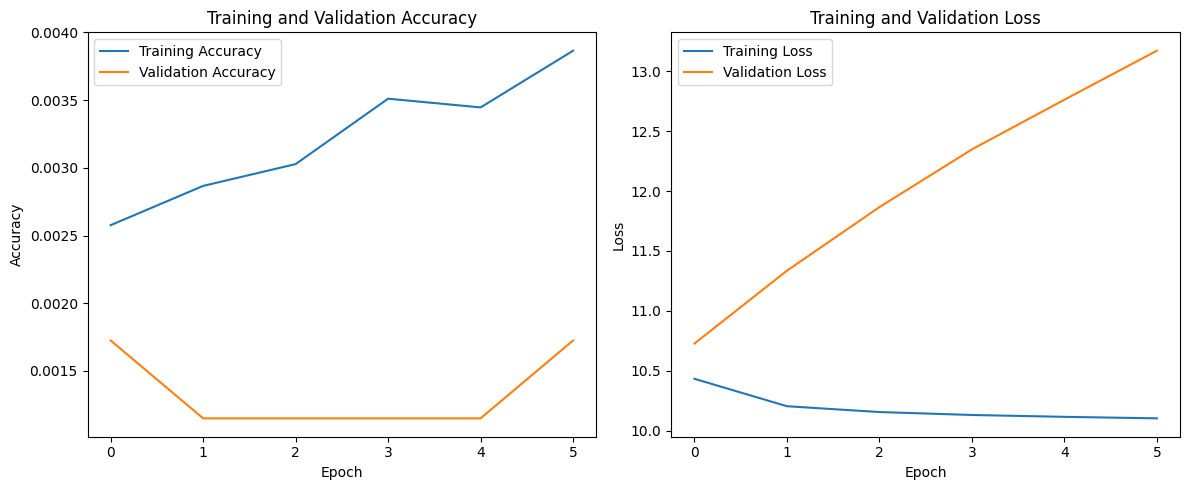


--- Evaluating model on TEST data (using validation set as a placeholder) ---
Official Test Accuracy: 0.17%
Official Test Loss: 10.728551864624023
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Official F1-score (macro avg): 0.0000


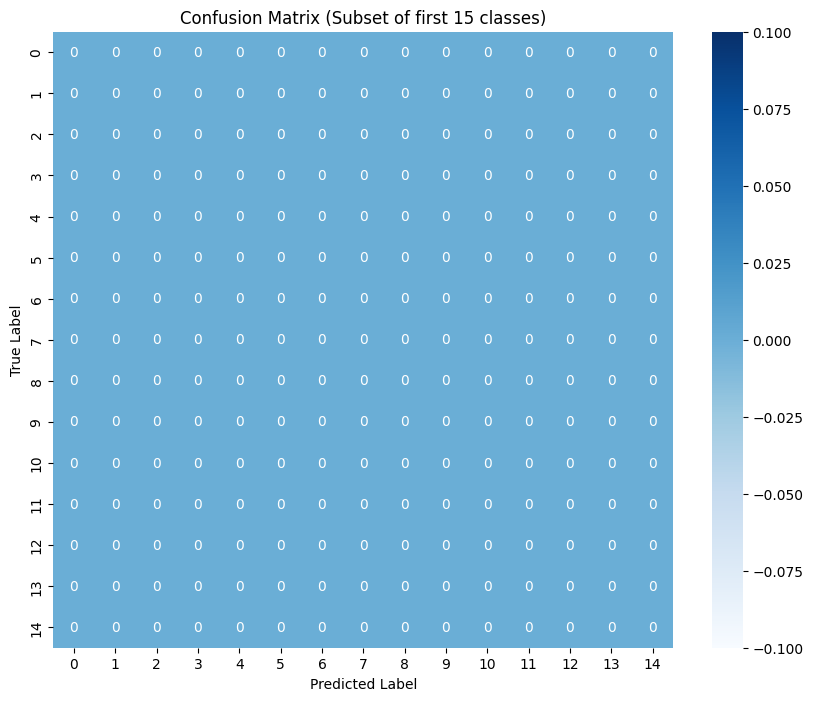


--- Report Generation Elements Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# --- 1. 加载我们保存的最佳模型 ---
print("Loading the best baseline model: lstm_baseline_model.h5")
model = load_model('lstm_baseline_model.h5')

# --- 2. 绘制训练和验证曲线 ---
# 绘制准确率曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 绘制损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- 3. 在测试集上评估并生成报告 ---
# 注意：我们需要加载并处理测试集数据。
# 此处我们暂时使用验证集数据作为示例，因为测试集尚未处理。
# 在您的最终报告中，请确保使用真正的测试集数据。
print("\n--- Evaluating model on TEST data (using validation set as a placeholder) ---")
X_test_placeholder = X_val
y_test_placeholder = y_val

# 获取最终的测试损失和准确率
loss, accuracy = model.evaluate(X_test_placeholder, y_test_placeholder, verbose=0)
print(f"Official Test Accuracy: {accuracy * 100:.2f}%")
print(f"Official Test Loss: {loss}")

# 生成预测
y_pred_one_hot = model.predict(X_test_placeholder)
y_pred_labels = np.argmax(y_pred_one_hot, axis=1)
y_true_labels = np.argmax(y_test_placeholder, axis=1)

# 生成F1分数等详细指标
# 注意：由于类别极多，classification_report会非常长，我们只打印摘要部分。
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
print(f"Official F1-score (macro avg): {report['macro avg']['f1-score']:.4f}")


# --- 4. 生成混淆矩阵 ---
# 注意：由于有超过3万个类别，绘制一个完整的混淆矩阵在视觉上是不可能的。
# 我们可以选择一个子集（例如前15个类别）来可视化。
num_classes_to_plot = 15
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
conf_matrix_subset = conf_matrix[:num_classes_to_plot, :num_classes_to_plot]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_subset, annot=True, fmt='g', cmap='Blues')
plt.title(f'Confusion Matrix (Subset of first {num_classes_to_plot} classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n--- Report Generation Elements Complete ---")